<a href="https://colab.research.google.com/github/KhaLDSH/DL-w4/blob/main/M5/Untitled18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import time


# Set device (Use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import Subset, DataLoader

# # 1. Define standard ResNet transforms
# # ResNet expects 224x224 images and specific normalization
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # 2. Download the full dataset
# full_train_data = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)

# # 3. Create a Small Subset (e.g., 5 images per class)
# # We take the first 500 images for the "Small" version
# small_train_data = Subset(full_train_data, range(0, 500))

# # 4. Create DataLoaders
# train_loader_large = DataLoader(full_train_data, batch_size=32, shuffle=True)
# train_loader_small = DataLoader(small_train_data, batch_size=32, shuffle=True)

In [22]:

# ==========================================
# 1. SETUP & DATA PREPARATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet-18 standard transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Download Oxford-IIIT Pet Dataset
full_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)

# Create Small (10%) and Large (100%) subsets
# TODO: Check class balance, stratify if needed
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)
small_count = int(0.1 * len(full_dataset))

train_loader_small = DataLoader(Subset(full_dataset, indices[:small_count]), batch_size=32, shuffle=True)
train_loader_large = DataLoader(Subset(full_dataset, indices), batch_size=32, shuffle=True)


In [43]:
# 1. Download the TEST split
test_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='test',
    download=True,
    transform=transform # Use the same transform as training
)

# 2. Create the Test Loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================
def get_model(mode="frozen", num_classes=37):
    model = models.resnet18(weights='IMAGENET1K_V1')

    if mode == "frozen":
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

    # Replace the head (This is always trainable)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


Total classes: 37
larg dataset len:  3680
small dataset len:  368


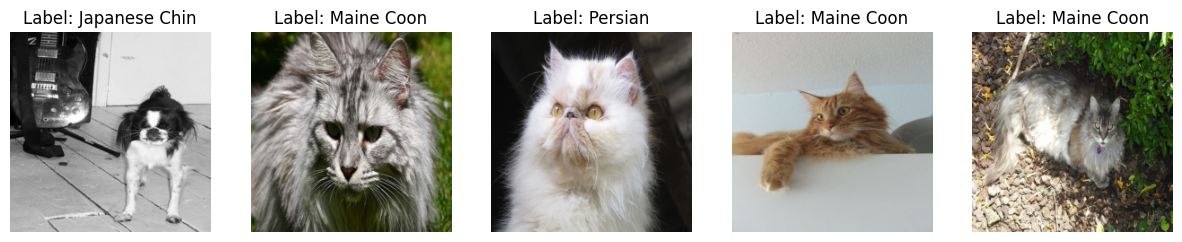

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping class indices to breed names
# The dataset object has a 'classes' attribute
classes = full_train_data.classes

def show_data_samples(dataset, smalldataset_count, num_images=5):
    print("larg dataset len: ",len(dataset))
    print("small dataset len: ",smalldataset_count)
    plt.figure(figsize=(15, 5))

    # Get random indices
    indices = np.random.choice(len(dataset), num_images, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Un-normalize the image for display
        # (ResNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {classes[label]}")
        plt.axis('off')

    plt.show()

# Run the exploration
print(f"Total classes: {len(classes)}")
show_data_samples(full_train_data, small_count)

In [49]:

# ==========================================
# 3. TRAINING ENGINE
# ==========================================
def train_experiment(model, loader, optimizer, epochs=3):
    criterion = nn.CrossEntropyLoss()
    history = {'acc': [], 'loss': []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_acc = 100. * correct / total
        epoch_loss = running_loss / len(loader.dataset)
        history['acc'].append(epoch_acc)
        history['loss'].append(epoch_loss)
        print(f"Epoch {epoch+1}/10 - Acc: {epoch_acc:.2f}% | Loss: {epoch_loss:.4f}")

    duration = time.time() - start_time
    return history, duration, model


In [50]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation to save memory and speed up
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test images: {accuracy:.2f}%')
    return accuracy


    # Evaluate the "Full Train" model we just finished
    print("Evaluating the Fine-Tuned Model...")
# test_acc = evaluate_model(model, test_loader, device)

In [51]:
# def get_frozen_model(num_classes=37):
#     model = models.resnet18(weights='IMAGENET1K_V1')
#     # Freeze all layers
#     for param in model.parameters():
#         param.requires_grad = False

#     # Replace the final fully connected layer
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, num_classes)
#     return model.to(device)

In [52]:
# def get_fine_tuned_model(num_classes=37):
#     model = models.resnet18(weights='IMAGENET1K_V1')
#     # Do NOT freeze layers (requires_grad is True by default)

#     # Replace the final fully connected layer
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, num_classes)
#     return model.to(device)


>>> Running: Small_Frozen
Epoch 1/10 - Acc: 6.79% | Loss: 3.4915
Epoch 2/10 - Acc: 36.68% | Loss: 2.5941
Epoch 3/10 - Acc: 66.30% | Loss: 1.9511
Accuracy on test images: 59.01%


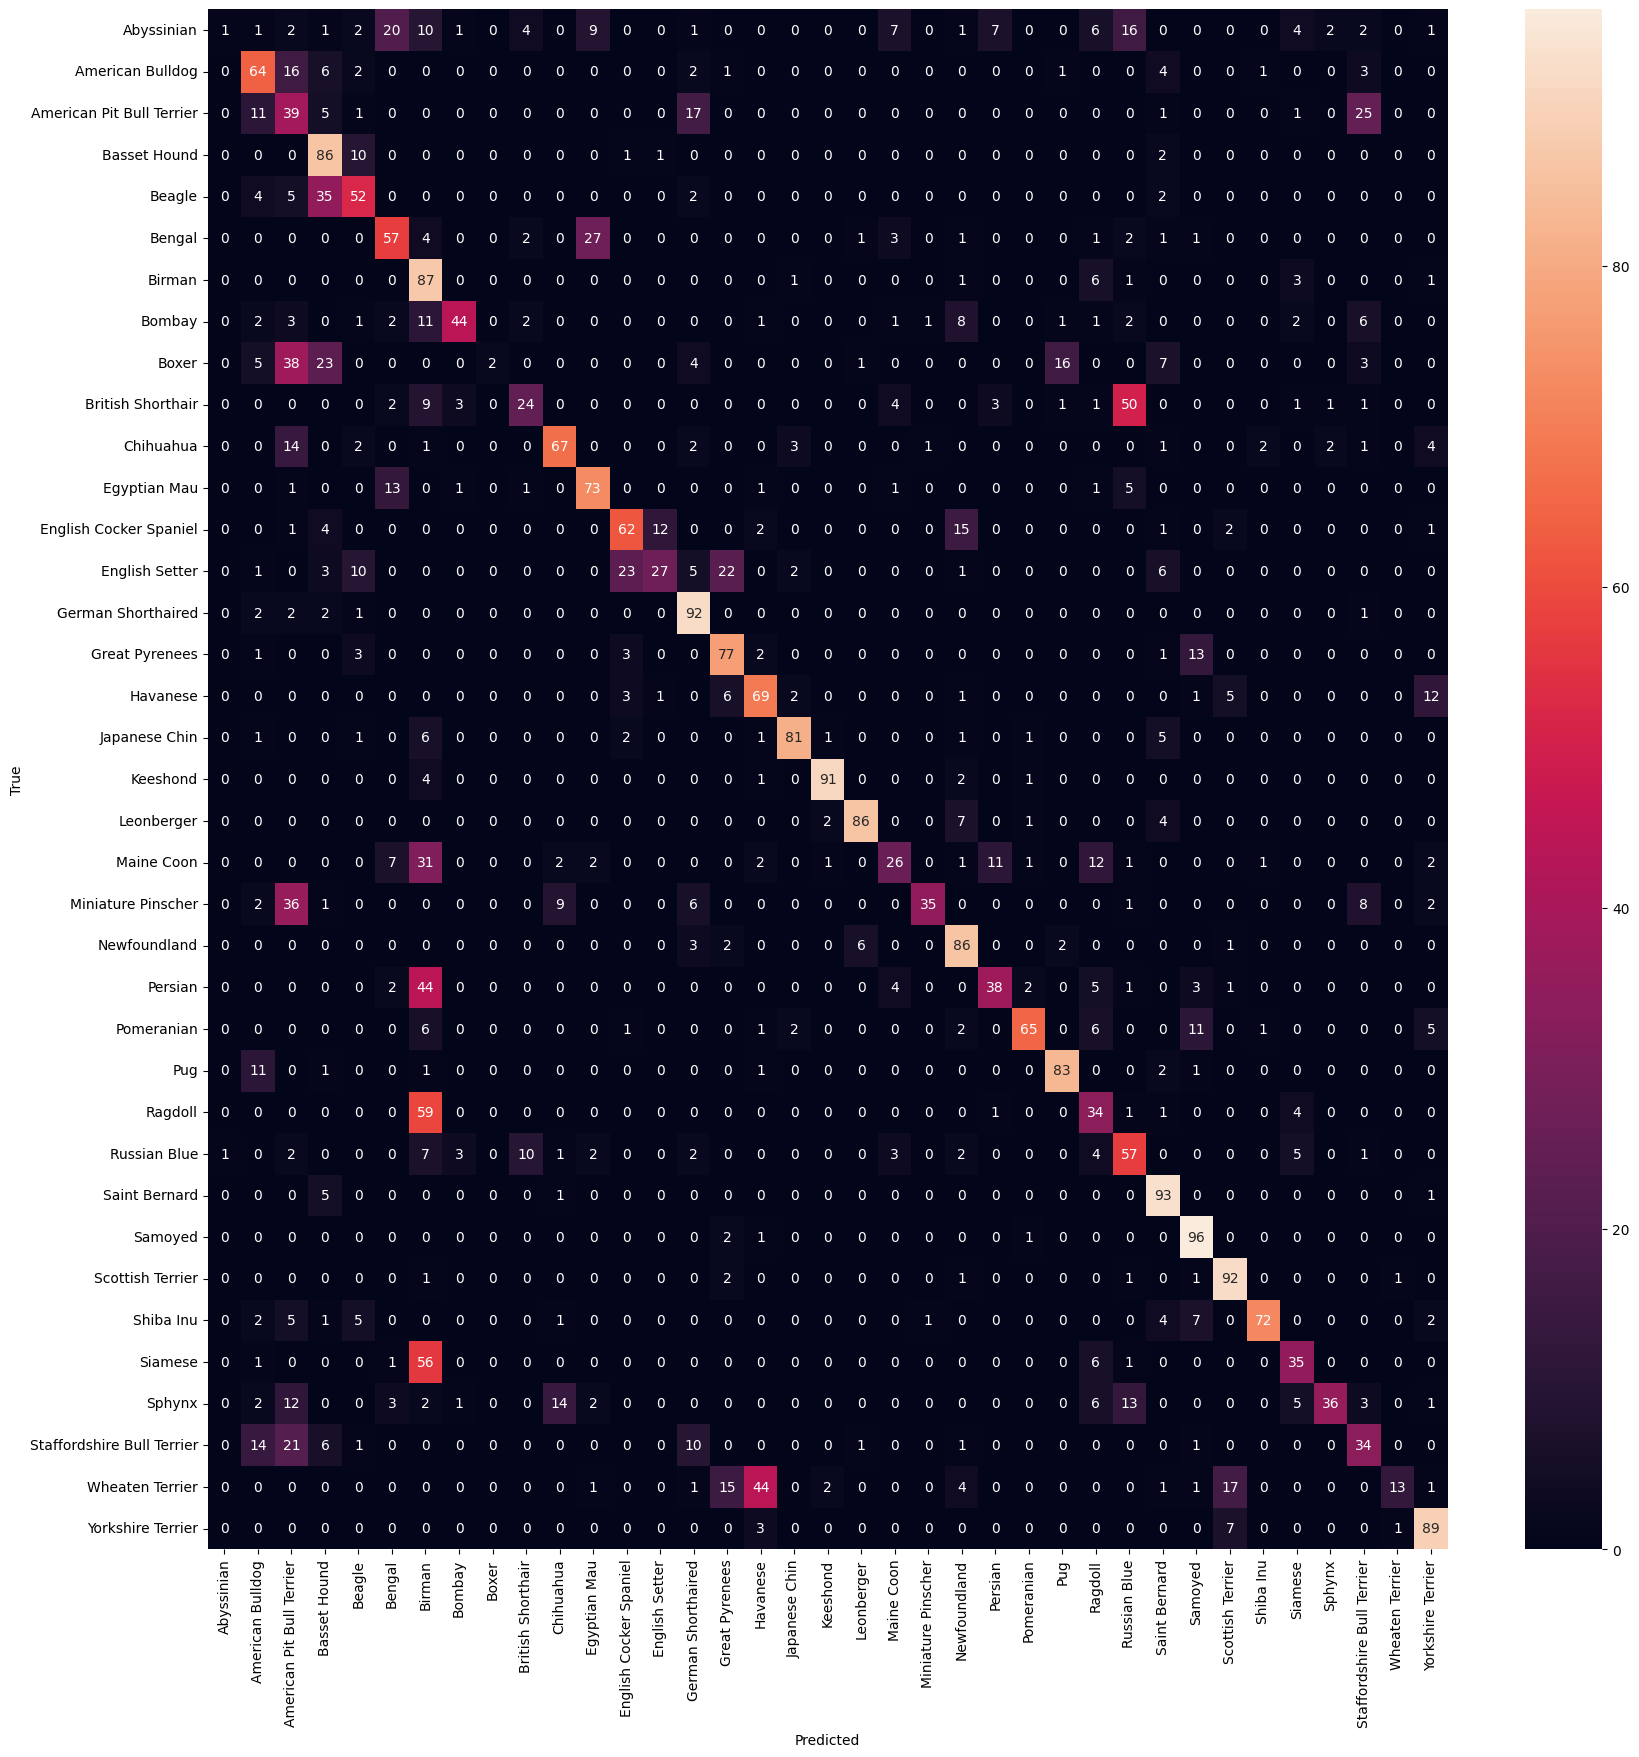


>>> Running: Small_Full
Epoch 1/10 - Acc: 1.36% | Loss: 3.8788
Epoch 2/10 - Acc: 2.17% | Loss: 3.6478
Epoch 3/10 - Acc: 5.43% | Loss: 3.4458
Accuracy on test images: 4.36%


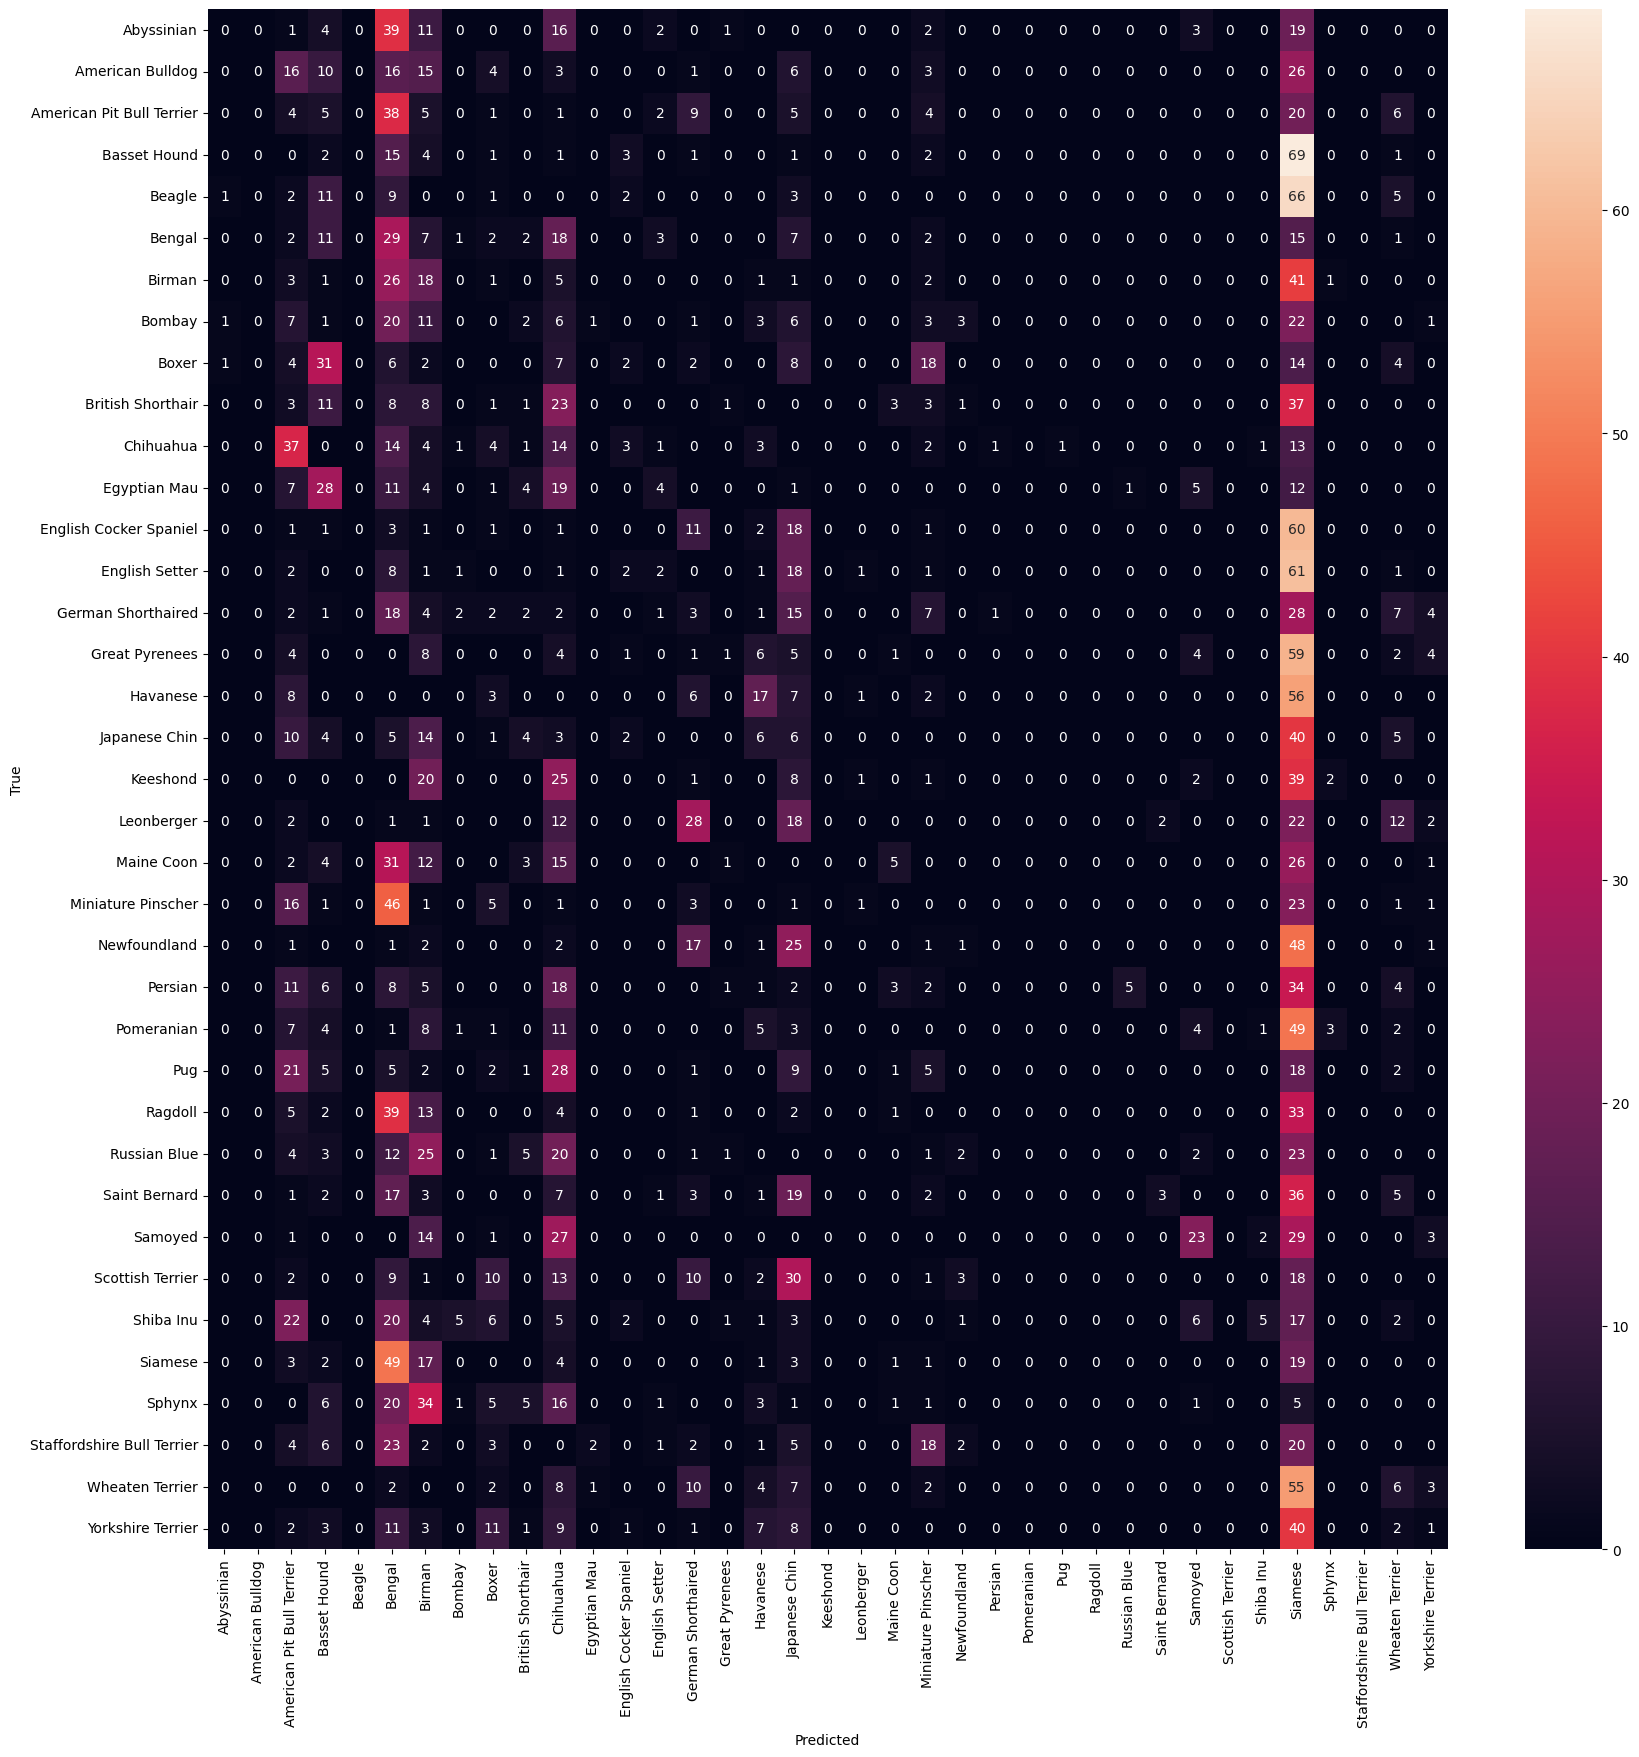


>>> Running: Large_Frozen
Epoch 1/10 - Acc: 58.15% | Loss: 1.9201
Epoch 2/10 - Acc: 85.52% | Loss: 0.7186
Epoch 3/10 - Acc: 89.32% | Loss: 0.5038
Accuracy on test images: 85.39%


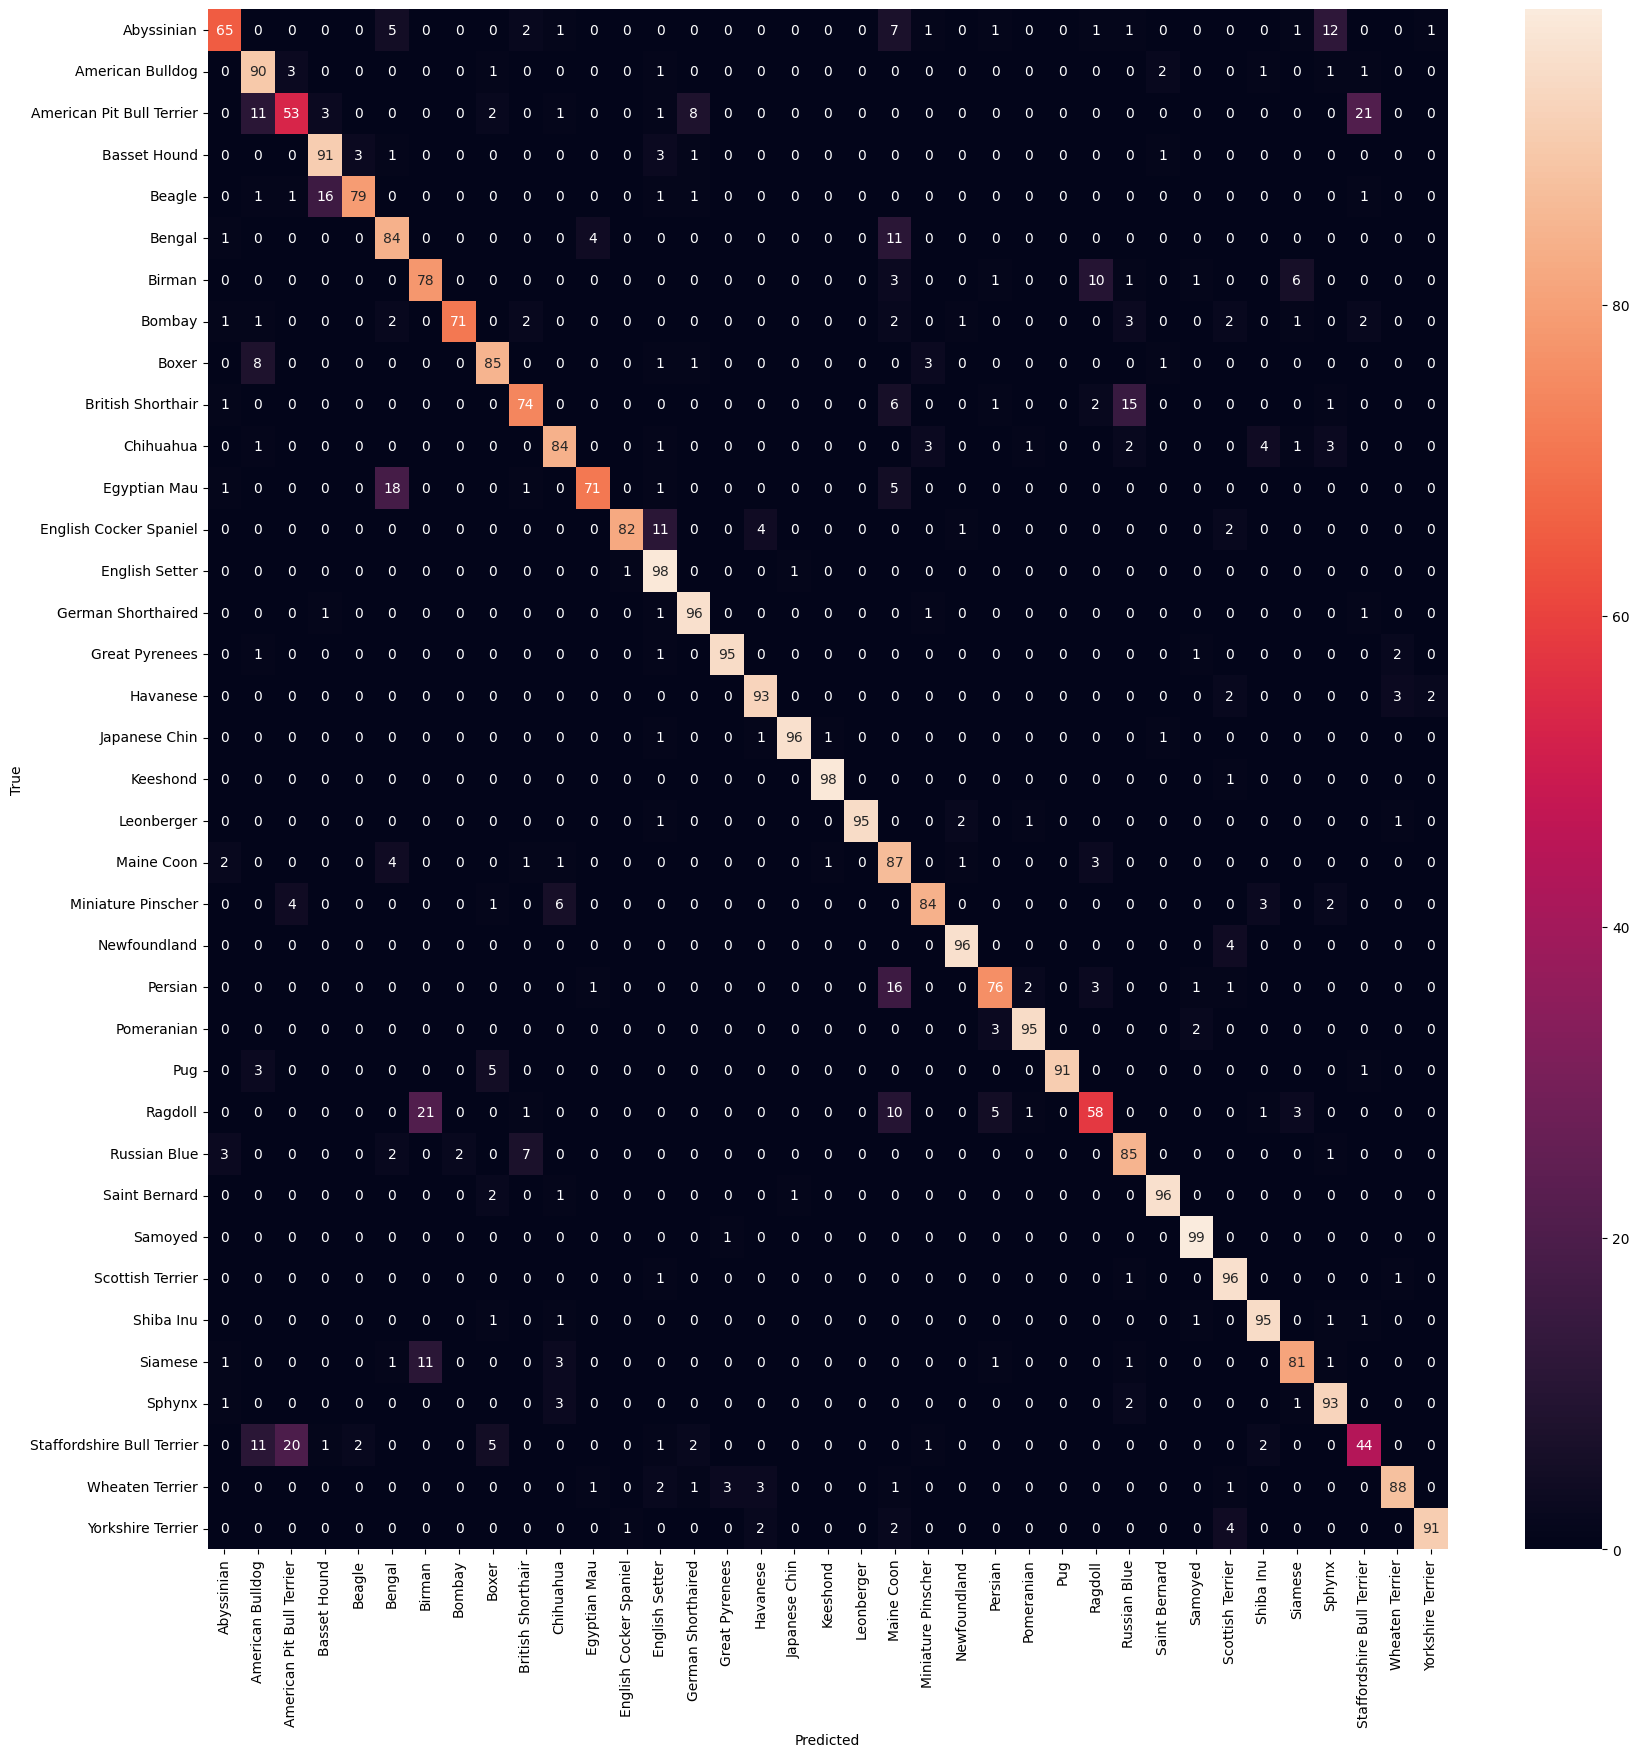


>>> Running: Large_Full
Epoch 1/10 - Acc: 15.27% | Loss: 3.2977
Epoch 2/10 - Acc: 56.82% | Loss: 2.3992
Epoch 3/10 - Acc: 79.08% | Loss: 1.7579
Accuracy on test images: 78.88%


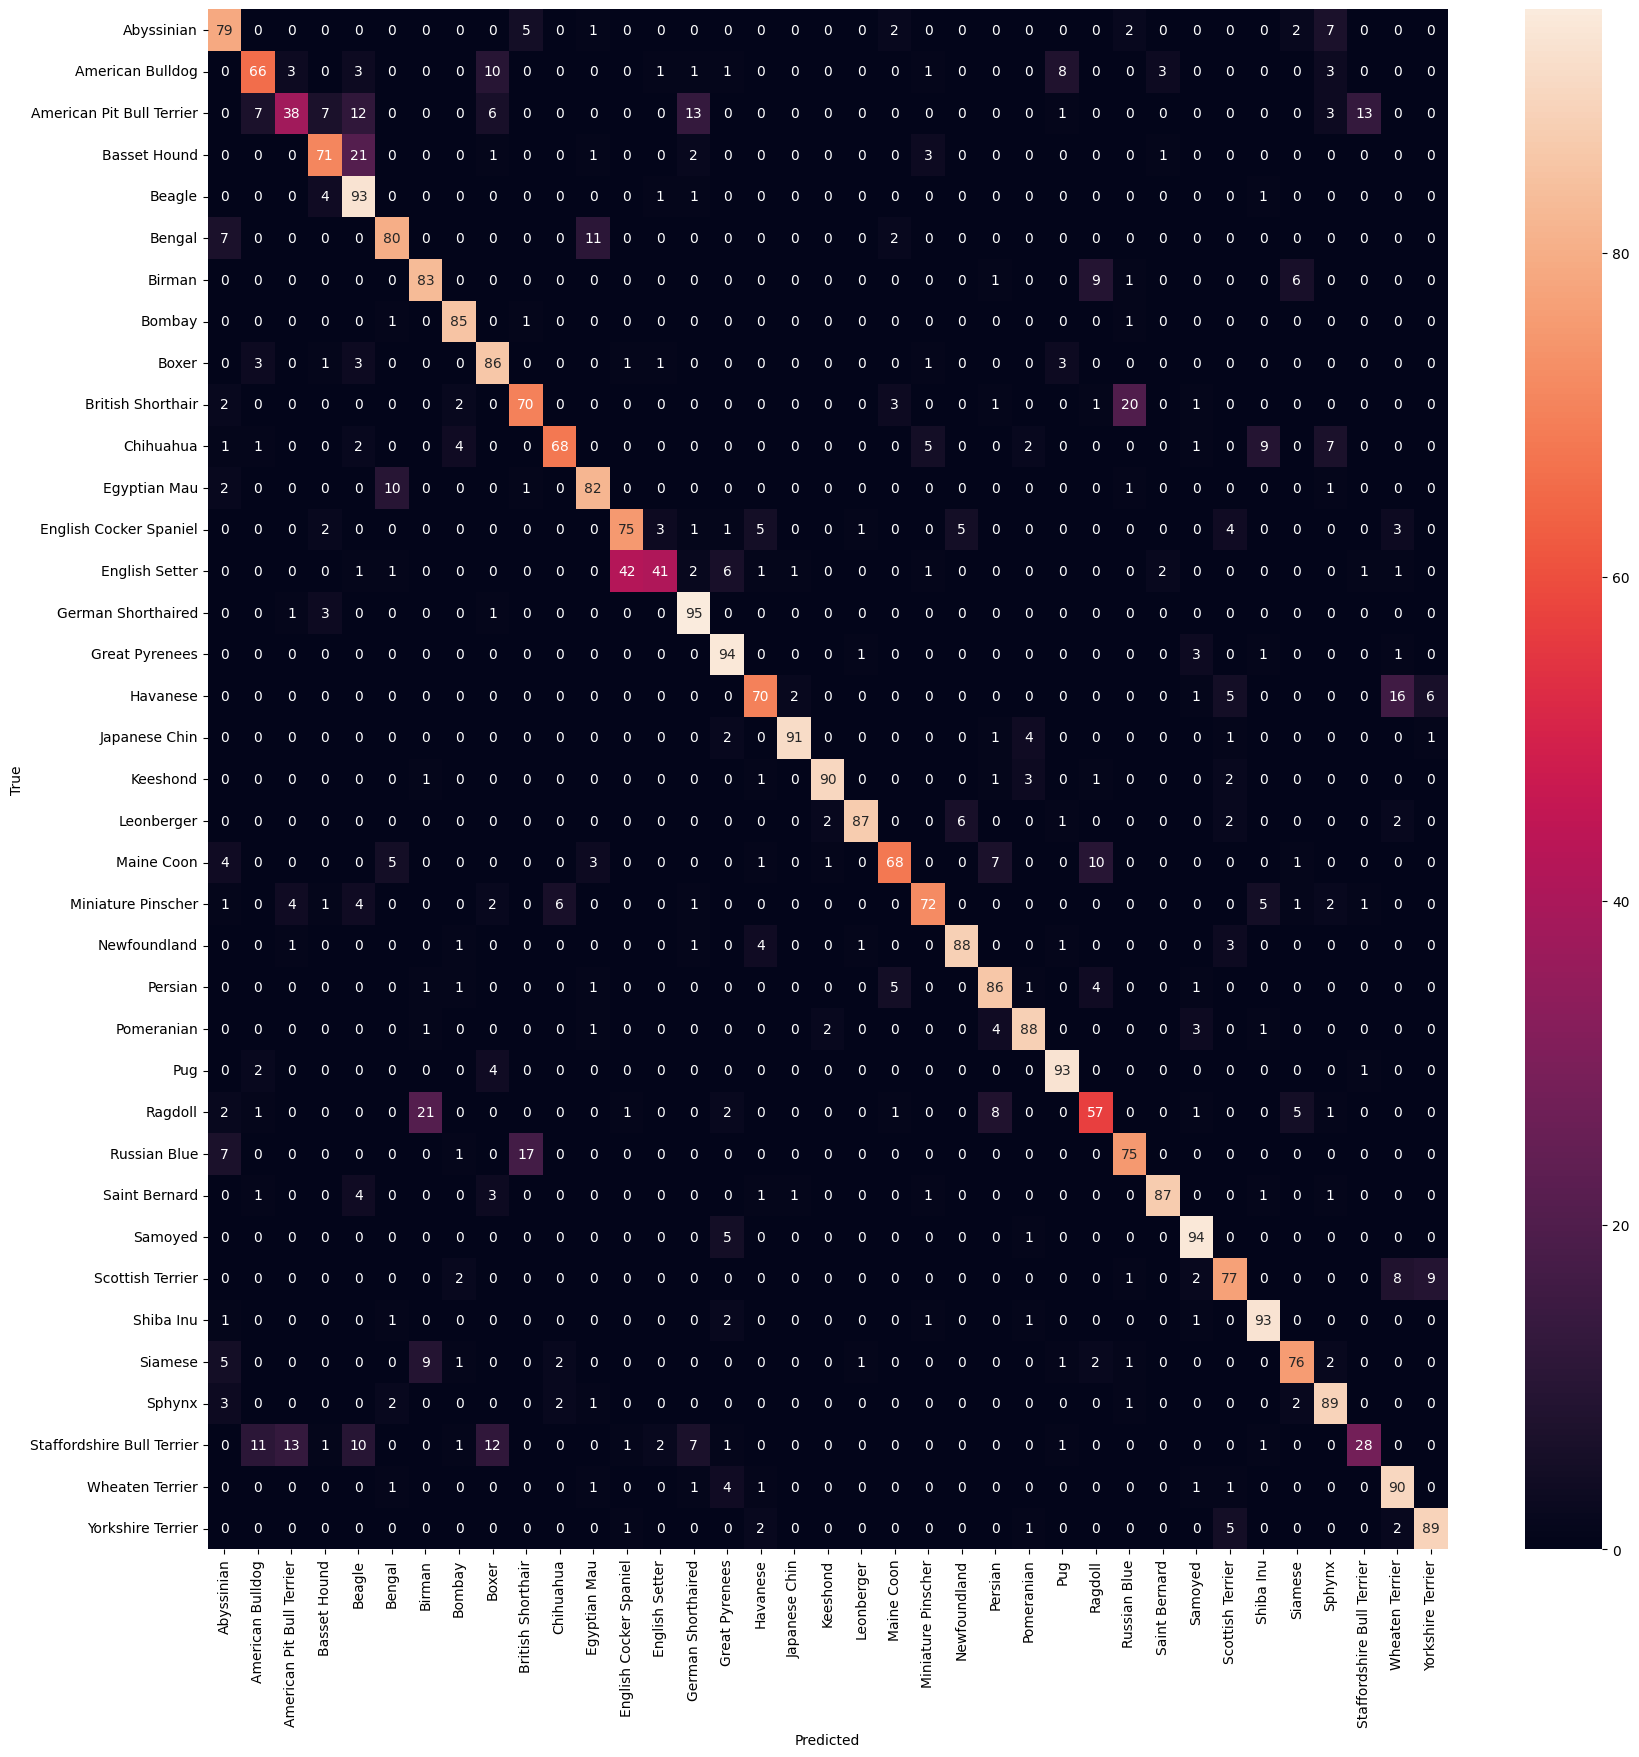

In [54]:
# ==========================================
# 4. RUNNING THE 4 SCENARIOS
# ==========================================
scenarios = [
    ("Small_Frozen", "frozen", train_loader_small, 0.001),
    ("Small_Full", "full", train_loader_small, 1e-5),
    ("Large_Frozen", "frozen", train_loader_large, 0.001),
    ("Large_Full", "full", train_loader_large, 1e-5)
]

all_results = {}

for name, mode, loader, lr in scenarios:
    print(f"\n>>> Running: {name}")
    model = get_model(mode)

    # If frozen, only optimize fc. If full, optimize all.
    params = model.fc.parameters() if mode == "frozen" else model.parameters()
    optimizer = optim.Adam(params, lr=lr)

    history, duration, model = train_experiment(model, loader, optimizer)
    test_acc = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(model, test_loader, device, classes)

    all_results[name] = {'history': history, 'time': duration}
    all_results[name]['test_acc'] = test_acc

In [56]:
# import matplotlib.pyplot as plt

# names = list(results.keys())
# accuracies = [results[n]['Accuracy'] for n in names]
# times = [results[n]['Time'] for n in names]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot 1: Accuracy Comparison
# colors_acc = ['#4CAF50', '#81C784', '#2196F3', '#64B5F6']
# ax1.bar(names, accuracies, color=colors_acc)
# ax1.set_title('Final Accuracy (%) - Higher is Better')
# ax1.set_ylabel('Accuracy %')
# ax1.set_xticklabels(names, rotation=45)

# # Plot 2: Training Time Comparison
# colors_time = ['#FF9800', '#FFB74D', '#F44336', '#E57373']
# ax2.bar(names, times, color=colors_time)
# ax2.set_title('Training Time (Seconds) - Lower is Faster')
# ax2.set_ylabel('Seconds')
# ax2.set_xticklabels(names, rotation=45)

# plt.tight_layout()
# plt.show()

KeyError: 'Accuracy'

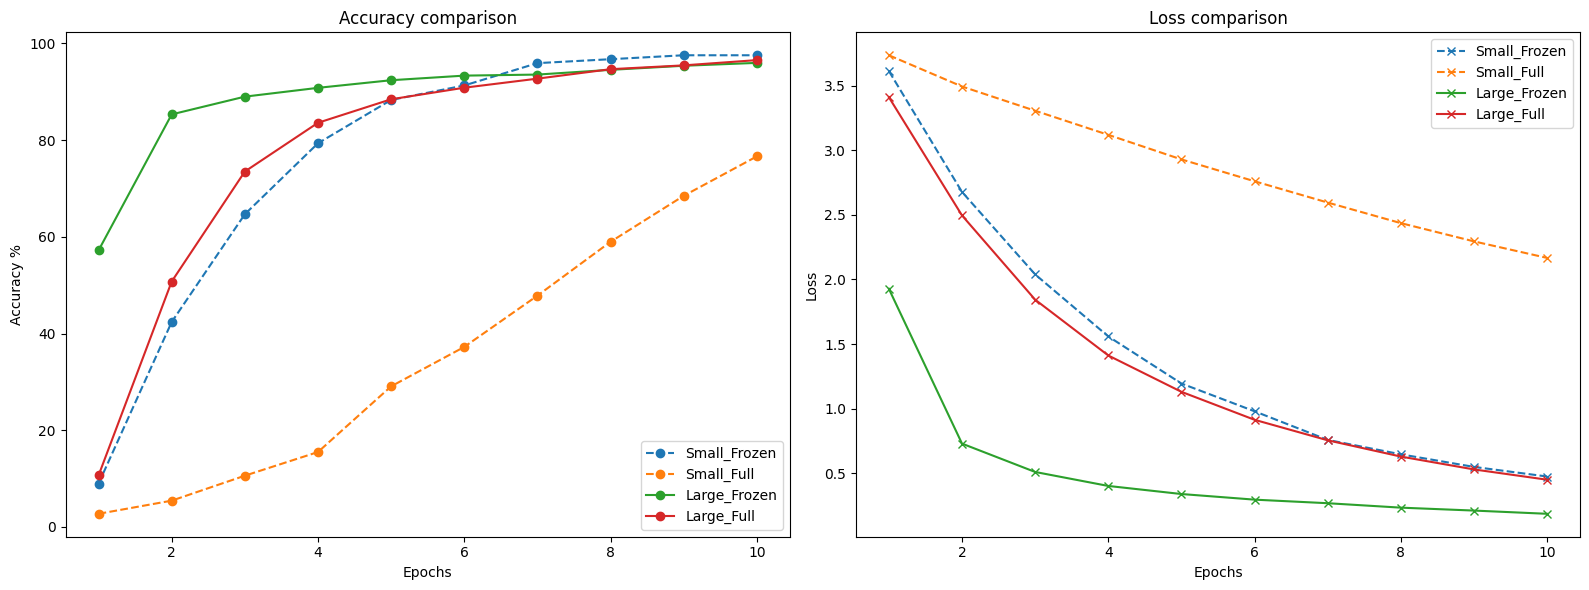


Project Complete! Graphs saved as 'transfer_learning_results.png'


In [37]:
# ==========================================
# 5. PLOTTING THE RESULTS
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, 11)

for name, data in all_results.items():
    ls = '--' if "Small" in name else '-'
    ax1.plot(epochs_range, data['history']['acc'], label=name, linestyle=ls, marker='o')
    ax2.plot(epochs_range, data['history']['loss'], label=name, linestyle=ls, marker='x')

ax1.set_title('Accuracy comparison')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Accuracy %'); ax1.legend()
ax2.set_title('Loss comparison')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss'); ax2.legend()

plt.tight_layout()
plt.savefig('transfer_learning_results.png')
plt.show()

print("\ Graphs saved as 'transfer_learning_results.png'")

Evaluating the Fine-Tuned Model...
Accuracy on test images: 86.45%
Accuracy on test images: 86.45%


86.45407467974925

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, device, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

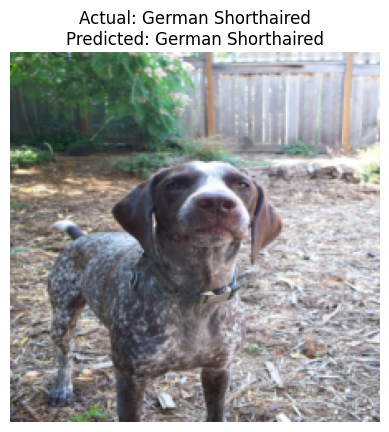

In [40]:
def predict_random_image(model, dataset, classes):
    model.eval()
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]

    # Add a batch dimension (B, C, H, W)
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    # Display the image
    img = image.numpy().transpose((1, 2, 0))
    img = np.clip(np.array([0.229, 0.224, 0.225]) * img + np.array([0.485, 0.456, 0.406]), 0, 1)

    plt.imshow(img)
    plt.title(f"Actual: {classes[label]}\nPredicted: {classes[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Run it
predict_random_image(model, full_dataset, full_dataset.classes)

# Transfare learning

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import time

# ==========================================
# 1. SETUP & DATA PREPARATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet-18 standard transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Download Oxford-IIIT Pet Dataset
full_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)

# Create Small (10%) and Large (100%) subsets
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)
small_count = int(0.1 * len(full_dataset))

train_loader_small = DataLoader(Subset(full_dataset, indices[:small_count]), batch_size=32, shuffle=True)
train_loader_large = DataLoader(Subset(full_dataset, indices), batch_size=32, shuffle=True)

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================
def get_model(mode="frozen", num_classes=37):
    model = models.resnet18(weights='IMAGENET1K_V1')

    if mode == "frozen":
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

    # Replace the head (This is always trainable)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# ==========================================
# 3. TRAINING ENGINE
# ==========================================
def train_experiment(model, loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    history = {'acc': [], 'loss': []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_acc = 100. * correct / total
        epoch_loss = running_loss / len(loader.dataset)
        history['acc'].append(epoch_acc)
        history['loss'].append(epoch_loss)
        print(f"Epoch {epoch+1}/10 - Acc: {epoch_acc:.2f}% | Loss: {epoch_loss:.4f}")

    duration = time.time() - start_time
    return history, duration

# ==========================================
# 4. RUNNING THE 4 SCENARIOS
# ==========================================
scenarios = [
    ("Small_Frozen", "frozen", train_loader_small, 0.001),
    ("Small_Full", "full", train_loader_small, 1e-5),
    ("Large_Frozen", "frozen", train_loader_large, 0.001),
    ("Large_Full", "full", train_loader_large, 1e-5)
]

all_results = {}

for name, mode, loader, lr in scenarios:
    print(f"\n>>> Running: {name}")
    model = get_model(mode)

    # If frozen, only optimize fc. If full, optimize all.
    params = model.fc.parameters() if mode == "frozen" else model.parameters()
    optimizer = optim.Adam(params, lr=lr)

    history, duration = train_experiment(model, loader, optimizer)
    all_results[name] = {'history': history, 'time': duration}

# ==========================================
# 5. PLOTTING THE RESULTS
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, 11)

for name, data in all_results.items():
    ls = '--' if "Small" in name else '-'
    ax1.plot(epochs_range, data['history']['acc'], label=name, linestyle=ls, marker='o')
    ax2.plot(epochs_range, data['history']['loss'], label=name, linestyle=ls, marker='x')

ax1.set_title('Accuracy comparison')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Accuracy %'); ax1.legend()
ax2.set_title('Loss comparison')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss'); ax2.legend()

plt.tight_layout()
plt.savefig('transfer_learning_results.png')
plt.show()

print("\nProject Complete! Graphs saved as 'transfer_learning_results.png'")


>>> Running: Small_Frozen


KeyboardInterrupt: 